In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# --- Параметри ---

latent_dim = 10  # Розмір латентного простору (кількість ознак, що описують кожне зображення після стиску)

batch_size = 128  # Розмір пакету (кількість зображень, які модель обробляє за один крок навчання)

reconstruction_loss_type = 'bce'  # 'bce' або 'mse'

beta = 4  # коефіцієнт для β-VAE (1 = звичайний VAE)

epochs = 50  # Кількість епох (повних проходів по всьому навчальному набору даних)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Визначення пристрою для обчислень: якщо доступна відеокарта (GPU) — використовувати її, інакше — CPU

In [3]:
# --- Завантаження MNIST ---

transform = transforms.ToTensor()
# Перетворення зображень у тензори PyTorch та нормалізація пікселів до діапазону [0, 1]

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)
# Завантаження навчального набору MNIST. Якщо його немає локально — буде завантажено з інтернету.
# Кожне зображення перетворюється на тензор за допомогою transform

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform, download=True
)
# Завантаження тестового набору MNIST з таким же перетворенням у тензори

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# Створення ітератора (DataLoader) для тренувального набору.
# Дані поділяються на батчі та перемішуються перед кожною епохою

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)
# Створення ітератора для тестового набору.
# Дані не перемішуються (shuffle=False), бо це не потрібно під час тестування

In [4]:
# --- Енкодер ---
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # Ініціалізація батьківського класу nn.Module

        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        # Перший згортковий шар: приймає 1 канал (сіре зображення), вихід — 32 фільтри розміром 3x3, крок — 2, паддінг — 1

        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        # Другий згортковий шар: вхід — 32 канали, вихід — 64, параметри ті ж

        self.fc1 = nn.Linear(64 * 7 * 7, 16)
        # Повнозв'язний шар після згорток: приймає розгортку зображення (64 канали по 7x7) і зменшує до 16 ознак

        self.fc_mean = nn.Linear(16, latent_dim)
        # Лінійний шар для обчислення середнього (μ) латентного розподілу

        self.fc_log_var = nn.Linear(16, latent_dim)
        # Лінійний шар для обчислення логарифма дисперсії (log σ²) латентного розподілу

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # Пропуск через перший згортковий шар + ReLU активація

        x = F.relu(self.conv2(x))
        # Пропуск через другий згортковий шар + ReLU активація

        x = x.view(x.size(0), -1)
        # Розгортання тензора в вектор ознак перед повнозв’язними шарами

        x = F.relu(self.fc1(x))
        # Повнозв’язний шар + ReLU

        z_mean = self.fc_mean(x)
        # Обчислення середнього значення латентного вектора

        z_log_var = self.fc_log_var(x)
        # Обчислення лог-дисперсії латентного вектора

        std = torch.exp(0.5 * z_log_var)
        # Обчислення стандартного відхилення σ = exp(0.5 * log(σ²))

        eps = torch.randn_like(std)
        # Генерація випадкового шуму ε того ж розміру, що і σ

        z = z_mean + eps * std
        # Репараметризація: z = μ + σ * ε

        return z, z_mean, z_log_var
        # Повертаємо латентний вектор та його статистичні параметри

In [5]:
# --- Декодер ---
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # Ініціалізація батьківського класу nn.Module

        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        # Повнозв'язний шар: перетворює латентний вектор у тензор, який можна подати на транспоновані згортки

        self.deconv1 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1)
        # Перший транспонований згортковий шар (деконволюція): збільшує розмірність з 7x7 до 14x14

        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        # Другий транспонований згортковий шар: збільшує розмірність з 14x14 до 28x28

        self.out = nn.Conv2d(32, 1, 3, padding=1)
        # Останній згортковий шар: зменшує кількість каналів з 32 до 1 (відновлене зображення)

    def forward(self, z):
        x = F.relu(self.fc(z))
        # Пропуск через повнозв'язний шар + ReLU

        x = x.view(-1, 64, 7, 7)
        # Зміна розмірності тензора до формату для деконволюції

        x = F.relu(self.deconv1(x))
        # Перша транспонована згортка + ReLU

        x = F.relu(self.deconv2(x))
        # Друга транспонована згортка + ReLU

        x = torch.sigmoid(self.out(x))
        # Вихідний шар з сигмоїдою — обмежує значення пікселів до [0, 1]

        return x
        # Повертаємо реконструйоване зображення

In [6]:
# --- VAE ---
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # Ініціалізація батьківського класу nn.Module

        self.encoder = Encoder(latent_dim)
        # Ініціалізуємо енкодер з заданим розміром латентного простору

        self.decoder = Decoder(latent_dim)
        # Ініціалізуємо декодер з таким самим розміром латентного простору

    def forward(self, x):
        z, z_mean, z_log_var = self.encoder(x)
        # Пропускаємо вхідне зображення через енкодер і отримуємо латентний вектор та параметри нормального розподілу

        recon = self.decoder(z)
        # Пропускаємо латентний вектор через декодер, отримуємо реконструйоване зображення

        return recon, z_mean, z_log_var
        # Повертаємо реконструкцію, середнє та лог-дисперсію для обчислення втрат

In [7]:
# --- Функція втрат ---
def loss_function(recon_x, x, mu, logvar, loss_type='bce', beta=1):
    if loss_type == 'bce':
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    elif loss_type == 'mse':
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    else:
        raise ValueError(f"Unknown reconstruction loss type: {loss_type}")
    
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + beta * kl_loss

In [8]:
# --- Навчання ---
vae = VAE(latent_dim).to(device)
# Ініціалізація моделі VAE з заданим розміром латентного простору та переміщенням її на GPU або CPU

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)
# Оптимізатор Adam для оновлення параметрів моделі з заданим коефіцієнтом навчання

for epoch in range(epochs):
    # Цикл навчання по кількості епох

    vae.train()
    # Перемикання моделі в режим навчання (важливо для шарів, як-от Dropout або BatchNorm)

    train_loss = 0
    # Ініціалізація змінної для накопичення втрати за епоху

    for batch in train_loader:
        # Ітерація по мінібатчам тренувального набору

        x, _ = batch
        # Отримання зображень (ігноруючи мітки)

        x = x.to(device)
        # Переміщення батчу на GPU або CPU

        optimizer.zero_grad()
        # Обнулення градієнтів перед зворотним поширенням

        recon, mu, logvar = vae(x)
        # Прогін вхідного зображення через VAE, отримання реконструкції, середнього та лог-дисперсії

        loss = loss_function(recon, x, mu, logvar, loss_type=reconstruction_loss_type, beta=beta)
        # Обчислення втрати VAE

        loss.backward()
        # Обчислення градієнтів через зворотне поширення

        train_loss += loss.item()
        # Додавання значення втрати до загального лосу для цієї епохи

        optimizer.step()
        # Оновлення параметрів моделі

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")
    # Виведення середньої втрати за епоху

Epoch 1, Loss: 308.0363
Epoch 2, Loss: 221.5973
Epoch 3, Loss: 211.5735
Epoch 4, Loss: 204.5152
Epoch 5, Loss: 199.3113
Epoch 6, Loss: 195.4098
Epoch 7, Loss: 192.1370
Epoch 8, Loss: 189.6686
Epoch 9, Loss: 187.2990
Epoch 10, Loss: 185.3660
Epoch 11, Loss: 183.6768
Epoch 12, Loss: 182.3207
Epoch 13, Loss: 181.1754
Epoch 14, Loss: 180.1558
Epoch 15, Loss: 179.1838
Epoch 16, Loss: 178.2765
Epoch 17, Loss: 177.6406
Epoch 18, Loss: 176.9356
Epoch 19, Loss: 176.3522
Epoch 20, Loss: 175.7406
Epoch 21, Loss: 175.1354
Epoch 22, Loss: 174.5882
Epoch 23, Loss: 174.1433
Epoch 24, Loss: 173.5610
Epoch 25, Loss: 173.1149
Epoch 26, Loss: 172.5573
Epoch 27, Loss: 172.1348
Epoch 28, Loss: 171.7516
Epoch 29, Loss: 171.2250
Epoch 30, Loss: 170.7921
Epoch 31, Loss: 170.2302
Epoch 32, Loss: 168.7468
Epoch 33, Loss: 167.8459
Epoch 34, Loss: 167.2822
Epoch 35, Loss: 166.7750
Epoch 36, Loss: 166.3900
Epoch 37, Loss: 165.9949
Epoch 38, Loss: 165.6339
Epoch 39, Loss: 165.2541
Epoch 40, Loss: 164.8153
Epoch 41,

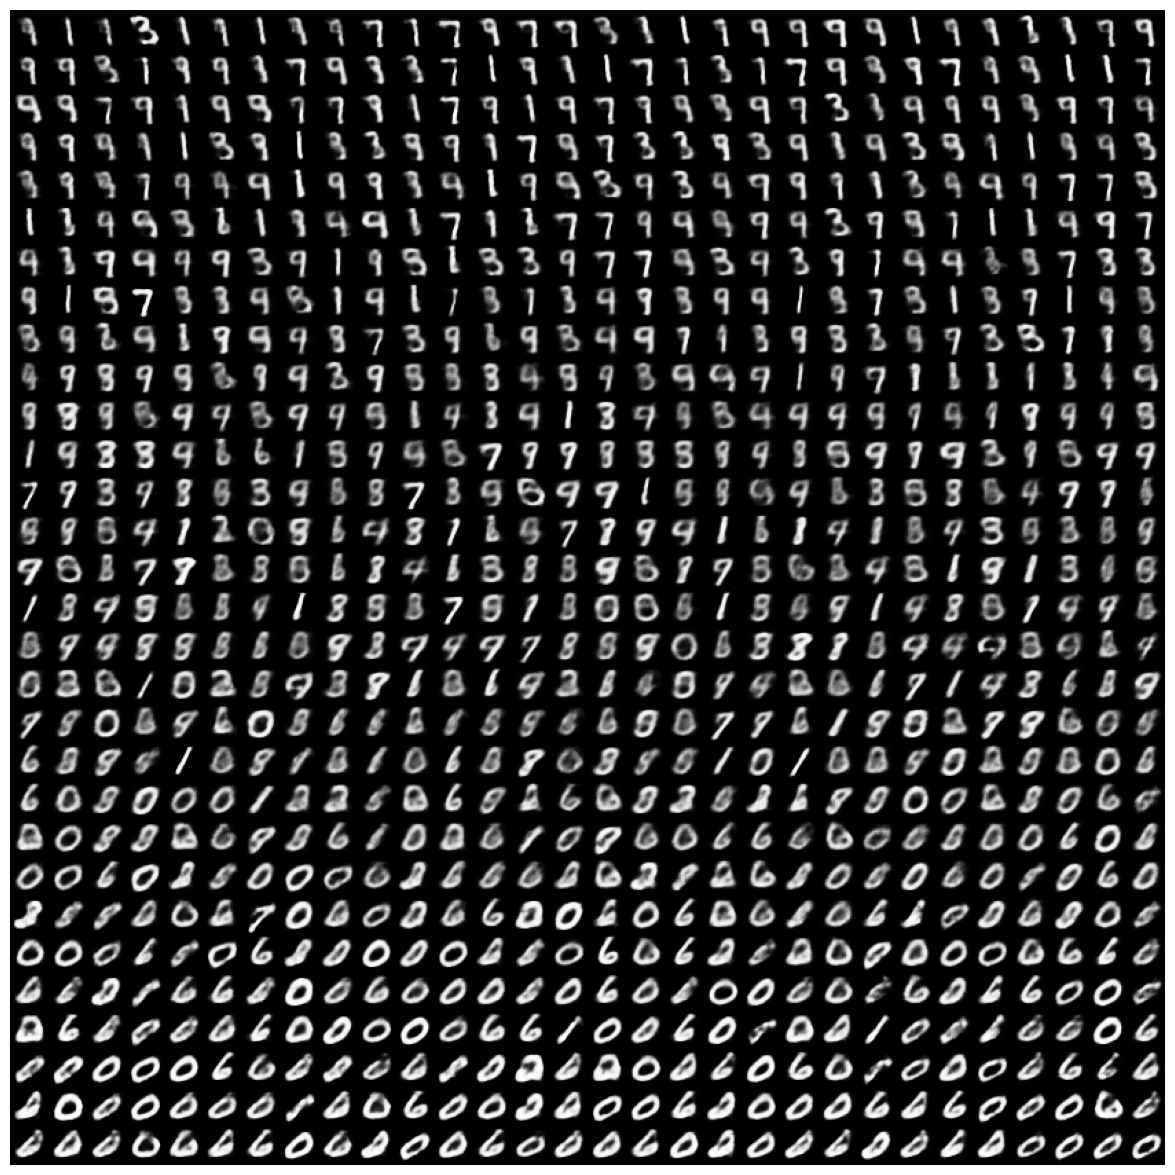

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- Візуалізація латентного простору ---
def plot_latent_space(decoder, latent_dim=10, n=30, figsize=15):
    # Функція для візуалізації латентного простору шляхом генерації зображень із різних точок
    # Аргументи:
    # - decoder: декодер VAE
    # - latent_dim: розмір латентного простору
    # - n: кількість зображень по кожній осі (сітка n x n)
    # - figsize: розмір фігури для matplotlib

    digit_size = 28
    # Розмір зображення (для MNIST — 28x28)

    scale = 3.0
    # Межі латентного простору, що буде візуалізовано (від -3 до 3)

    figure = np.zeros((digit_size * n, digit_size * n))
    # Ініціалізація великого зображення, яке буде складене з n*n згенерованих цифр

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    # Побудова координатної сітки латентного простору (Y розгортається для правильного відображення)

    decoder.eval()
    # Перемикання декодера в режим оцінки (inference)

    with torch.no_grad():
        # Вимкнення обчислення градієнтів для пришвидшення генерації

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = torch.zeros((1, latent_dim), dtype=torch.float32).to(device)
                z_sample[0, 0] = xi  # зміна першої координати латентного простору
                z_sample[0, 1] = yi  # зміна другої координати латентного простору

                # Генерація випадкового шуму для решти координат
                z_sample[:, 2:] = torch.randn((1, latent_dim - 2), dtype=torch.float32).to(device)

                x_decoded = decoder(z_sample).cpu().numpy()[0, 0]
                # Декодування точки в зображення та приведення до NumPy, вибір каналу (0, бо grayscale)

                figure[i * digit_size : (i + 1) * digit_size,
                       j * digit_size : (j + 1) * digit_size] = x_decoded
                # Вставка згенерованого зображення в відповідну позицію у великому зображенні

    plt.figure(figsize=(figsize, figsize))
    # Створення фігури заданого розміру

    plt.imshow(figure, cmap="Greys_r")
    # Відображення великого зображення у відтінках сірого

    plt.axis("off")
    # Вимкнення осей для візуальної чистоти

    plt.show()
    # Показ результату

# Виклик функції для візуалізації
plot_latent_space(vae.decoder, latent_dim=10, n=30, figsize=15)